In [1]:
%cd /data/gunsbrother/prjs/ltvu/ours/
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/data/gunsbrother/prjs/ltvu/ours


In [2]:
def nms_1d(ivs, scores, overlap=0.5):
	"""
	Args:
		ivs: np.array, [N, 2]
		scores: np.array, [N]
		overlap: float

	Returns: np.array, [N', 2]
	"""
	if len(ivs) == 0:
		return []
	ivs = ivs[np.argsort(scores)[::-1]]
	pick = []
	while len(ivs) > 0:
		pick.append(ivs[0])
		if len(ivs) == 1:
			break
		ious = np.array([max(0, min(ivs[0][1], iv[1]) - max(ivs[0][0], iv[0])) / (max(ivs[0][1], iv[1]) - min(ivs[0][0], iv[0])) for iv in ivs[1:]])
		ivs = ivs[1:][ious < overlap]
	return np.array(pick)

In [3]:
p_scores_dir = Path('results/without_rgb/mips/tmp')
records = []
for p_pkl in p_scores_dir.glob('*.pkl'):
    model_name = p_pkl.stem
    iogts = pickle.load(open(p_pkl, 'rb'))['iogts']
    for thres in [.3, .5]:
        pos_mask = iogts > thres
        for k in range(1, 1+iogts.shape[1]):
            records.append({
                'model': model_name,
                'k': k,
                'thres': thres,
                'score': pos_mask[:, :k].any(axis=1).mean() * 100
            })
df = pd.DataFrame(records)
df

,model,k,thres,score
0,egovlp,1,0.3,10.937500
1,egovlp,2,0.3,17.187500
2,egovlp,3,0.3,18.750000
3,egovlp,4,0.3,25.000000
4,egovlp,5,0.3,32.812500
...,...,...,...,...
75,multi-qa-mpnet-base-dot-v1,16,0.5,83.593750
76,multi-qa-mpnet-base-dot-v1,17,0.5,85.271140
77,multi-qa-mpnet-base-dot-v1,18,0.5,86.810662
78,multi-qa-mpnet-base-dot-v1,19,0.5,87.637868


In [5]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

                         model   k  thres      score
0                       egovlp   1    0.3  10.937500
1                       egovlp   2    0.3  17.187500
2                       egovlp   3    0.3  18.750000
3                       egovlp   4    0.3  25.000000
4                       egovlp   5    0.3  32.812500
5                       egovlp   6    0.3  32.812500
6                       egovlp   7    0.3  39.062500
7                       egovlp   8    0.3  43.750000
8                       egovlp   9    0.3  50.000000
9                       egovlp  10    0.3  53.125000
10                      egovlp  11    0.3  65.625000
11                      egovlp  12    0.3  67.187500
12                      egovlp  13    0.3  76.562500
13                      egovlp  14    0.3  82.812500
14                      egovlp  15    0.3  84.375000
15                      egovlp  16    0.3  90.625000
16                      egovlp  17    0.3  92.187500
17                      egovlp  18    0.3  95.

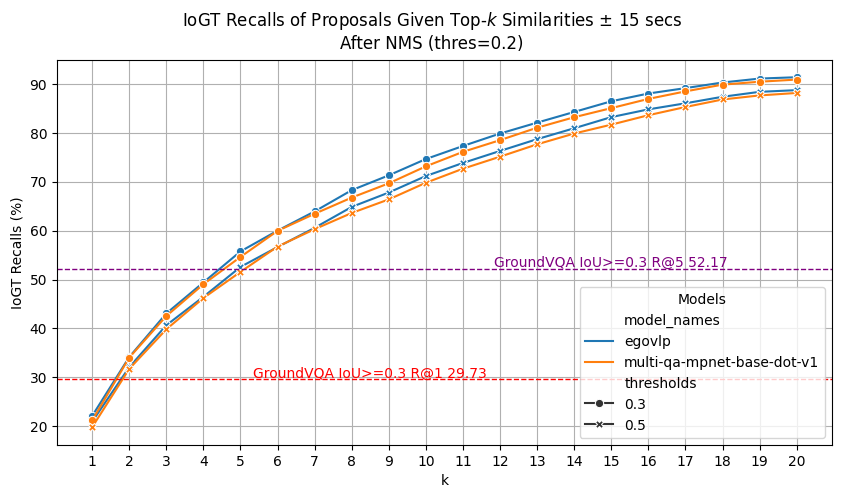

In [79]:
# model as hue, thres as saturation
plt.figure(figsize=(10, 5))
colname_mappings = {
    'model': 'model_names',
    'thres': 'thresholds',
    'score': 'IoGT Recalls (%)',
}
sns.lineplot(
    data=df.rename(columns=colname_mappings), markers=True, dashes=False,
    x='k',
    y=colname_mappings['score'],
    hue=colname_mappings['model'],
    style=colname_mappings['thres'])
plt.legend(title='Models')
plt.suptitle(rf"IoGT Recalls of Proposals Given Top-$k$ Similarities $\pm$ 15 secs{'\n'}After NMS (thres=0.2)")
plt.xticks(range(1, 1+iogts.shape[1]))
plt.grid()
plt.text(8.5, 30, 'GroundVQA IoU>=0.3 R@1 29.73', color='r', ha='center')
plt.axhline(29.73, color='r', linestyle='--', lw=1)
plt.text(15, 52.6, 'GroundVQA IoU>=0.3 R@5 52.17', color='purple', ha='center')
plt.axhline(52.17, color='purple', linestyle='--', lw=1)
plt.show()

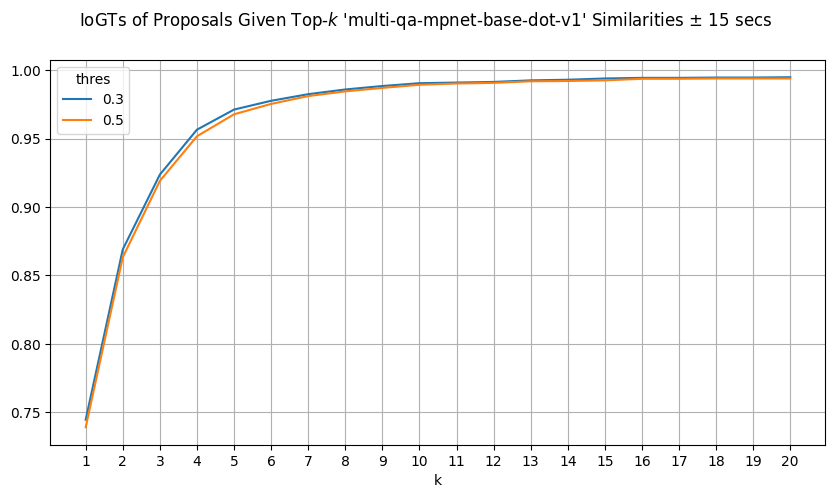

In [39]:
plt.figure(figsize=(10, 5))
df.pivot(index='k', columns='thres', values='score').plot(ax=plt.gca())
plt.suptitle(rf"IoGTs of Proposals Given Top-$k$ '{model_name}' Similarities $\pm$ 15 secs")
plt.xticks(range(1, 1+iogts.shape[1]))
plt.grid()
plt.show()

# Sanity Check

In [62]:
%cd /data/gunsbrother/prjs/ltvu/ours/
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch

/data/gunsbrother/prjs/ltvu/ours


In [70]:
p_pkl = 'results/without_rgb/mips/tmp/egovlp.pkl'
minor_infos = pickle.load(open(p_pkl, 'rb'))
minor_infos.keys()

dict_keys(['iogts', 'ious', 'preds', 'gts'])

In [71]:
iogts = minor_infos['iogts'].reshape(-1, 20)
ious = minor_infos['ious'].reshape(-1, 20)
preds = minor_infos['preds'].reshape(-1, 20, 2)  # [N, 20, 2]
gts = minor_infos['gts'].reshape(-1, 2)
preds.shape, gts.shape

((4352, 20, 2), (4352, 2))

iogt: [0.         0.         0.91666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
iou: [0.         0.         0.35483871 0.         0.         0.
 0.         0.         0.         0.         0.27272727 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


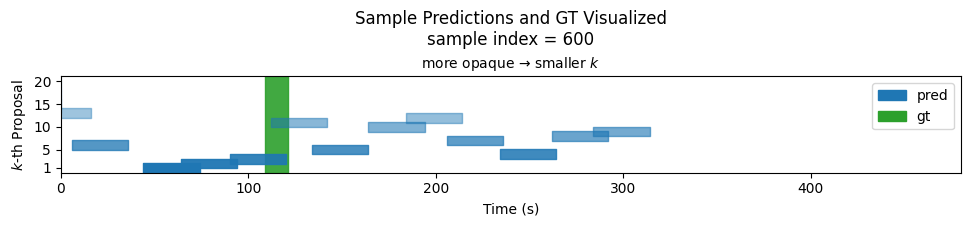

In [114]:
duration = 480
k = preds.shape[1]

idx = 600
print(f'iogt: {iogts[idx]}')
print(f'iou: {ious[idx]}')
rng = np.random.RandomState(0)
plt.figure(figsize=(10, 1.75))
height = .1
plt.fill_betweenx(y=[0, 0], x1=0, x2=0, color=plt.cm.tab10(0), alpha=1., label='pred')
plt.fill_betweenx(y=[0, 0], x1=0, x2=0, color=plt.cm.tab10(2), alpha=1., label='gt')
plt.fill_betweenx(y=[0, 1], x1=gts[idx, 0], x2=gts[idx, 1], color=plt.cm.tab10(2), alpha=.9)
y0s = np.linspace(0, 1-height, k)
for y0, (s, e) in zip(y0s, preds[idx]):
    # y0 = rng.rand() * (1 - height)
    plt.fill_betweenx(
        y=[y0, y0+height], x1=s, x2=e, color=plt.cm.tab10(0), alpha=1-y0)
plt.xlim(0, duration)
plt.ylim(0, 1)
plt.legend()
plt.yticks([height/2] + (height/2+y0s[4::5]).tolist(), [1] + list(range(1, 1+k))[4::5])
plt.xlabel('Time (s)')
plt.ylabel('$k$-th Proposal')
plt.suptitle(f'Sample Predictions and GT Visualized\nsample index = {idx}')
plt.title('more opaque → smaller $k$', fontsize=10)
plt.subplots_adjust(left=.05, right=.95, top=.6, bottom=.05)
plt.show()